In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

import utils

In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano
from exoplanet.gp import terms, GP

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # thx dfm

In [3]:
xlim_data = np.array([10.2, 10.8]) * 86400 # for selecting all data
xlim_plot = [890000, 895000] # for zoomed-in plots

#### Try fitting a GP to a short timeseries of single-mode RV oscillations:

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

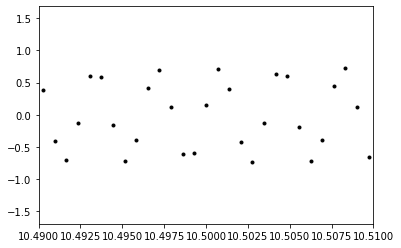

In [5]:
plt.plot(ts_onemode/86400., rvs_onemode, 'k.')
plt.xlim([10.49,10.51]);

In [6]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
24it [00:01, 18.78it/s, logp=7.609279e+01] 
message: Optimization terminated successfully.
logp: 32.25956935181088 -> 76.09279191067463


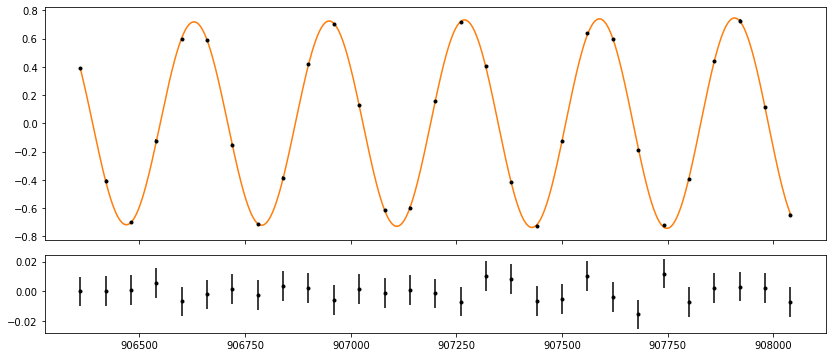

In [7]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [8]:
map_soln

{'logS0': array(-7.61160117),
 'logw0': array(-3.92939735),
 'logQ': array(9.86272482)}

This isn't quite what we expected - our calculation from `01-simulating-data.ipynb` was:
```
log_S0: -9.33721059
log_Q: 8.13423472
log_omega0: -3.92565541
```
BUT we do have an amplitudes issue when actually generating RVs from a GP with the above kernel and comparing to the RVs that we're using here, so maybe our expected logS0 is incorrect anyway.

#### Try with multi-mode RVs:

In [9]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_multimode = np.copy(d['ts'])
rvs_multimode = np.copy(d['rvs'])
xs_multimode = np.copy(d['xs'])

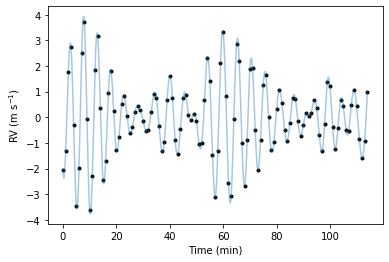

In [10]:
from scipy.interpolate import interp1d
inds = (ts_multimode/86400. > 20.) & (ts_multimode/86400. < 20.08)
short_ts = ts_multimode[inds] - np.min(ts_multimode[inds])
short_rvs = rvs_multimode[inds]
plt.plot(short_ts/60., short_rvs, 'k.')
interp = interp1d(short_ts, short_rvs, kind='cubic', assume_sorted=True)
xs = np.arange(np.min(short_ts), np.max(short_ts), 0.0005)
plt.plot(xs/60., interp(xs), alpha=0.4)
plt.xlabel('Time (min)')
plt.ylabel(r'RV (m s$^{-1}$)');

In [11]:
inds = (ts_multimode > 10. * 86400) & (ts_multimode < 12. * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(xlim_plot[0], xlim_plot[1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
41it [00:00, 168.56it/s, logp=3.171036e+02]
message: Optimization terminated successfully.
logp: -9030.986365068642 -> 317.1036119189756


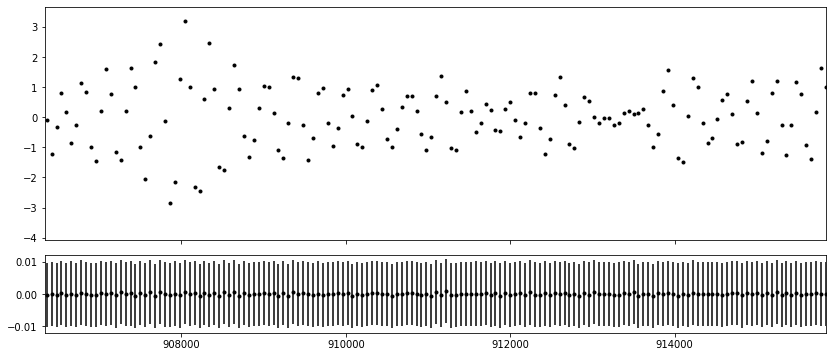

In [12]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids")

ax2.set_xlim(np.array([10.49,10.6]) * 86400);

In [13]:
map_soln

{'logS0': array(0.34463349),
 'logw0': array(-3.88582194),
 'logQ': array(3.50136344)}

In [14]:
map_soln

{'logS0': array(0.34463349),
 'logw0': array(-3.88582194),
 'logQ': array(3.50136344)}

This is also an excellent fit, even though we only used one mode.

#### multi-mode RVs, sparser data:

In [15]:
inds = (ts_multimode > xlim_data[0]) & (ts_multimode < xlim_data[1])
t_all = ts_multimode[inds]
y_all = rvs_multimode[inds]
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

In [16]:
inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = t_all[inds]
y = y_all[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(xlim_plot[0], xlim_plot[1], 1000)

In [17]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
75it [00:00, 265.61it/s, logp=-2.216076e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -2479.0671759144125 -> -221.60761564677995


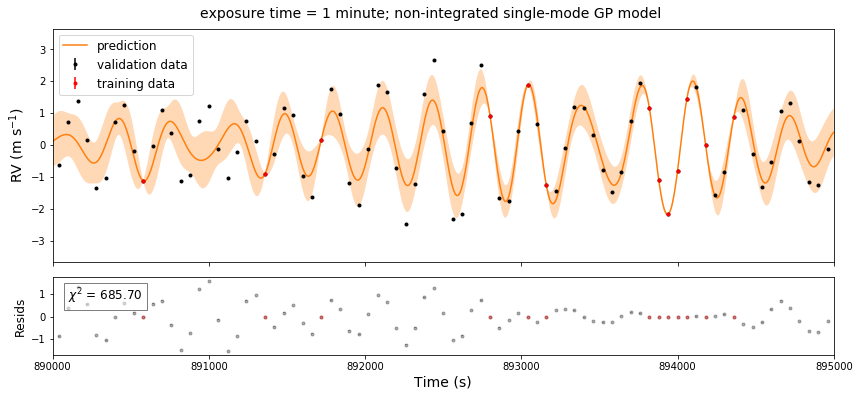

In [18]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14);
#fig.savefig('GPvalidation_1min.png');

OK good, so this doesn't work perfectly well for predicting! Let's test whether the same predictions get any better if the GP kernel we use has the entire comb of modes.

In [19]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling

freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]

#print("log_S0_grid: {0}".format(log_S0_grid))
#print("log(omega_grid): {0}".format(np.log(omega_grid)))
#print("log(Q_grid): {0}".format(np.log(omega_grid/gamma)))

##### note: the following code is quite slow. maybe should do this hierarchically.

In [20]:
%%time
with pm.Model() as model:
    # Set up the kernel and GP
    kernel = None
    logS0_vars = np.array([])
    logw0_vars = []
    logQ_vars = []
    
    for i,(o,lS) in enumerate(zip(omega_grid,log_S0_grid)):
        lSv = pm.Normal("logS0_{0}".format(i), mu=lS, sd=15.0)
        lwv = pm.Normal("logw0_{0}".format(i), mu=np.log(o), sd=2.0)
        lQv = pm.Normal("logQ_{0}".format(i), mu=np.log(o/gamma), sd=2.0)
        # add variables:
        logS0_vars = np.append(logS0_vars, lSv)
        logw0_vars = np.append(logw0_vars, lwv)
        logQ_vars = np.append(logQ_vars, lQv)
        # add kernel:
        if kernel is None:
            kernel = terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)
        else:
            kernel += terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ_15, logw0_15, logS0_15, logQ_14, logw0_14, logS0_14, logQ_13, logw0_13, logS0_13, logQ_12, logw0_12, logS0_12, logQ_11, logw0_11, logS0_11, logQ_10, logw0_10, logS0_10, logQ_9, logw0_9, logS0_9, logQ_8, logw0_8, logS0_8, logQ_7, logw0_7, logS0_7, logQ_6, logw0_6, logS0_6, logQ_5, logw0_5, logS0_5, logQ_4, logw0_4, logS0_4, logQ_3, logw0_3, logS0_3, logQ_2, logw0_2, logS0_2, logQ_1, logw0_1, logS0_1, logQ_0, logw0_0, logS0_0]
267it [00:04, 59.97it/s, logp=-2.386855e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -53614.49698497117 -> -23868.55213926995


CPU times: user 49.5 s, sys: 2.57 s, total: 52.1 s
Wall time: 53.2 s


/Users/mbedell/miniconda3/envs/pmodes/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


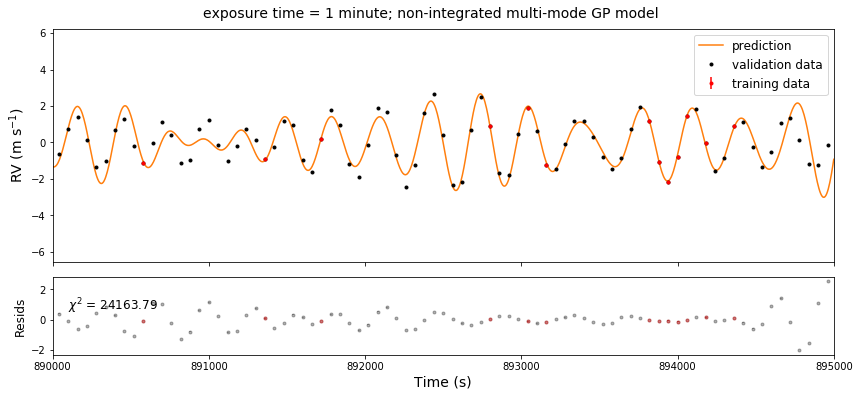

In [21]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.plot(ts_multimode, rvs_multimode, ".k", label="validation data")
ax1.errorbar(t, y, yerr=yerr, fmt=".r", capsize=0, label="training data")
ax1.legend(fontsize=12)

ax2.errorbar(t_all, y_all - y_pred_all, yerr=yerr_all, fmt=".k", capsize=0, alpha=0.3)
ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".r", capsize=0, alpha=0.3)

inds = (t_all > xlim_plot[0]) & (t_all < xlim_plot[1])
chisq = np.sum(((y_all - y_pred_all)/yerr_all)[inds])**2
ax2.text(xlim_plot[0] + 100, 0.6, r'$\chi^2$ = {0:.2f}'.format(chisq), fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim(xlim_plot)
fig.suptitle('exposure time = 1 minute; non-integrated multi-mode GP model', y=0.93, fontsize=14);

In [22]:
print(map_soln)

{'logS0_0': array(-13.491291), 'logw0_0': array(-4.31003064), 'logQ_0': array(11.49477004), 'logS0_1': array(-12.44192761), 'logw0_1': array(-4.26849606), 'logQ_1': array(11.73185808), 'logS0_2': array(-11.54341199), 'logw0_2': array(-4.21187773), 'logQ_2': array(10.36322265), 'logS0_3': array(-10.7961094), 'logw0_3': array(-4.15741641), 'logQ_3': array(10.92276113), 'logS0_4': array(-10.20032929), 'logw0_4': array(-4.10481274), 'logQ_4': array(11.22119054), 'logS0_5': array(-9.75633613), 'logw0_5': array(-4.03649003), 'logQ_5': array(11.27730201), 'logS0_6': array(-9.46435774), 'logw0_6': array(-3.99263656), 'logQ_6': array(10.10415594), 'logS0_7': array(-9.32459171), 'logw0_7': array(-3.96852217), 'logQ_7': array(9.83146844), 'logS0_8': array(-9.33721059), 'logw0_8': array(-3.94577723), 'logQ_8': array(11.13835153), 'logS0_9': array(-9.50236591), 'logw0_9': array(-3.90312638), 'logQ_9': array(10.56663882), 'logS0_10': array(-9.82019145), 'logw0_10': array(-3.86697292), 'logQ_10': arr

Try this as a hierarchical model with the following:

hyperparameters $\nu_{max}$, $\Delta\nu$, $a_{max}$, $c_{env}$, $\gamma$

**Note:** Not sure about use of gamma; also, might be missing some $2\pi$ factors due to $\nu$/$\omega$ inconsistencies.

### Longer-integration observations

Now that we're satisfied the GP works in general, let's test how it performs for observations that are integrated over longer times.

In [23]:
inds = (ts_multimode > 10.2 * 86400) & (ts_multimode < 10.8 * 86400)
exp_time = 5. * 60. #seconds
start_ts = ts_multimode[inds]
mid_rvs = np.array([utils.simulate_exposure(ts_multimode, rvs_multimode, tt, exp_time) for tt in start_ts])
mid_ts = start_ts + exp_time/2.

In [24]:
t_all = mid_ts
y_all = mid_rvs
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = mid_ts[inds]
y = mid_rvs[inds]
yerr = yerr_all[inds]
t_grid = np.linspace(xlim_plot[0], xlim_plot[1], 1000)

#### integrated exposures modeled with single-SHO kernel non-integrated GP:

In [25]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
109it [00:00, 207.03it/s, logp=1.712876e+02]
message: Optimization terminated successfully.
logp: 87.31544818985407 -> 171.28764713507493


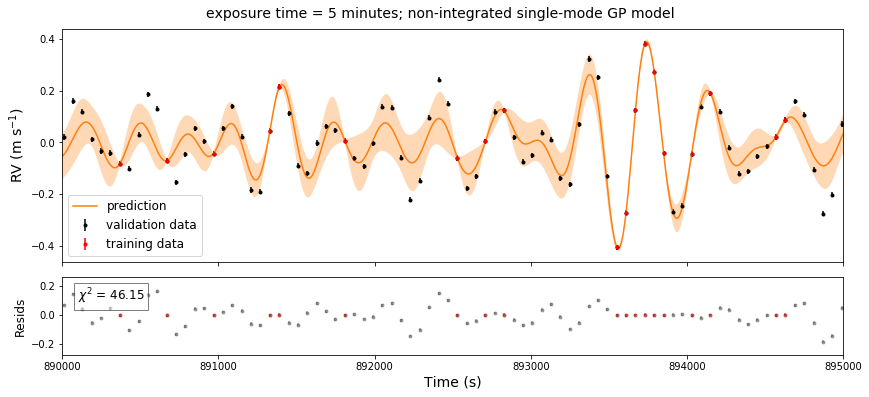

In [26]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
fig.savefig('GPvalidation_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

In [27]:
print(map_soln)

{'logS0': array(-1.86449311), 'logw0': array(-4.06716021), 'logQ': array(1.90401829)}


#### integrated exposures modeled with single-SHO kernel integrated GP:

In [28]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=5.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=5.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
22it [00:00, 212.55it/s, logp=1.350584e+02]
message: Optimization terminated successfully.
logp: -589.5377402319788 -> 135.05842463391133


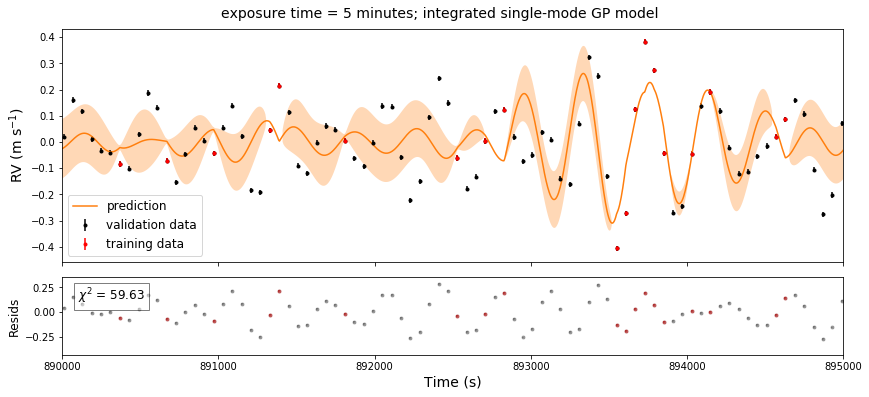

In [29]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
fig.savefig('GPvalidation_{0:.0f}min_integrated.png'.format(exp_time/60.));

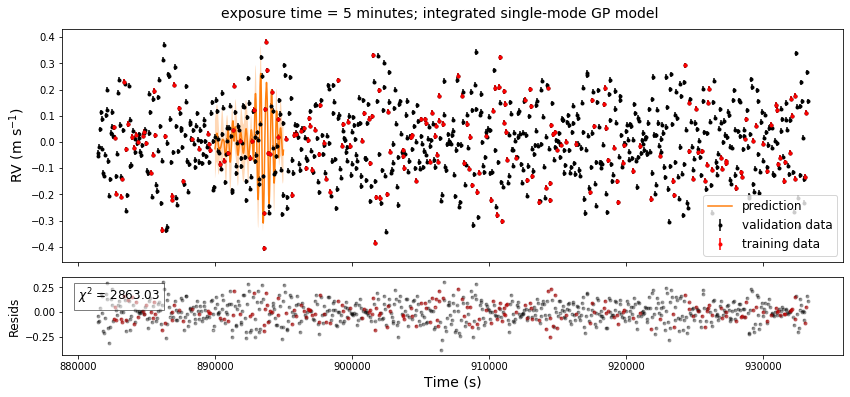

In [30]:
fig = utils.plot_validation_test_full(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);

In [31]:
print(map_soln)

{'logS0': array(-0.0702277), 'logw0': array(-4.04546791), 'logQ': array(2.76362795)}


#### optimal kernel parameters:
(we'll need these for the next step)

In [32]:
# use several nights of data:
inds = (ts_onemode > 8. * 86400) & (ts_onemode < 12. * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!

In [33]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    #mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    #sd = np.sqrt(var)
    #y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    #y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
73it [00:00, 120.16it/s, logp=1.710261e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 9468.042276740145 -> 17102.608999612225


In [34]:
print('optimal parameters from fitting single-mode RVs with a single-mode model:')
print(map_soln)

optimal parameters from fitting single-mode RVs with a single-mode model:
{'logS0': array(-6.65559527), 'logw0': array(-3.9255768), 'logQ': array(8.74891179)}


In [35]:
# use several nights of data:
inds = (ts_multimode > 8. * 86400) & (ts_multimode < 12. * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!

In [36]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    #mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    #sd = np.sqrt(var)
    #y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    #y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
170it [00:01, 112.39it/s, logp=-3.491625e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -26674.195177895497 -> -34.91625462445346


In [37]:
print('optimal parameters from fitting multi-mode RVs with a single-mode model:')
print(map_soln)

optimal parameters from fitting multi-mode RVs with a single-mode model:
{'logS0': array(0.7055492), 'logw0': array(-3.9235824), 'logQ': array(3.53210767)}


In [38]:
%%time
with pm.Model() as model:
    # Set up the kernel and GP
    kernel = None
    logS0_vars = np.array([])
    logw0_vars = []
    logQ_vars = []
    
    for i,(o,lS) in enumerate(zip(omega_grid,log_S0_grid)):
        lSv = pm.Normal("logS0_{0}".format(i), mu=lS, sd=15.0)
        lwv = pm.Normal("logw0_{0}".format(i), mu=np.log(o), sd=2.0)
        lQv = pm.Normal("logQ_{0}".format(i), mu=np.log(o/gamma), sd=2.0)
        # add variables:
        logS0_vars = np.append(logS0_vars, lSv)
        logw0_vars = np.append(logw0_vars, lwv)
        logQ_vars = np.append(logQ_vars, lQv)
        # add kernel:
        if kernel is None:
            kernel = terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)
        else:
            kernel += terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    #mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    #sd = np.sqrt(var)
    #y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    #y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ_15, logw0_15, logS0_15, logQ_14, logw0_14, logS0_14, logQ_13, logw0_13, logS0_13, logQ_12, logw0_12, logS0_12, logQ_11, logw0_11, logS0_11, logQ_10, logw0_10, logS0_10, logQ_9, logw0_9, logS0_9, logQ_8, logw0_8, logS0_8, logQ_7, logw0_7, logS0_7, logQ_6, logw0_6, logS0_6, logQ_5, logw0_5, logS0_5, logQ_4, logw0_4, logS0_4, logQ_3, logw0_3, logS0_3, logQ_2, logw0_2, logS0_2, logQ_1, logw0_1, logS0_1, logQ_0, logw0_0, logS0_0]
301it [00:47,  6.38it/s, logp=-4.906373e+05]

CPU times: user 1min 7s, sys: 8.71 s, total: 1min 16s
Wall time: 1min 18s



message: Desired error not necessarily achieved due to precision loss.
logp: -774542.7433780171 -> -490637.2950811082


In [39]:
print('optimal parameters from fitting multi-mode RVs with a multi-mode model:')
print(map_soln)

optimal parameters from fitting multi-mode RVs with a multi-mode model:
{'logS0_0': array(-13.491291), 'logw0_0': array(-4.32686037), 'logQ_0': array(9.87659173), 'logS0_1': array(-12.44192761), 'logw0_1': array(-4.2680877), 'logQ_1': array(11.876831), 'logS0_2': array(-11.54341199), 'logw0_2': array(-4.2106028), 'logQ_2': array(10.95944374), 'logS0_3': array(-10.7961094), 'logw0_3': array(-4.16012317), 'logQ_3': array(11.12756125), 'logS0_4': array(-10.20032929), 'logw0_4': array(-4.10681165), 'logQ_4': array(11.66233054), 'logS0_5': array(-9.75633613), 'logw0_5': array(-4.05682488), 'logQ_5': array(9.75078235), 'logS0_6': array(-9.46435774), 'logw0_6': array(-3.99850703), 'logQ_6': array(11.13278137), 'logS0_7': array(-9.32459171), 'logw0_7': array(-3.90752408), 'logQ_7': array(11.14272592), 'logS0_8': array(-9.33721059), 'logw0_8': array(-3.9473626), 'logQ_8': array(11.32992806), 'logS0_9': array(-9.50236591), 'logw0_9': array(-3.86034697), 'logQ_9': array(10.58466772), 'logS0_10': 